### Figure 5: remaze analyses

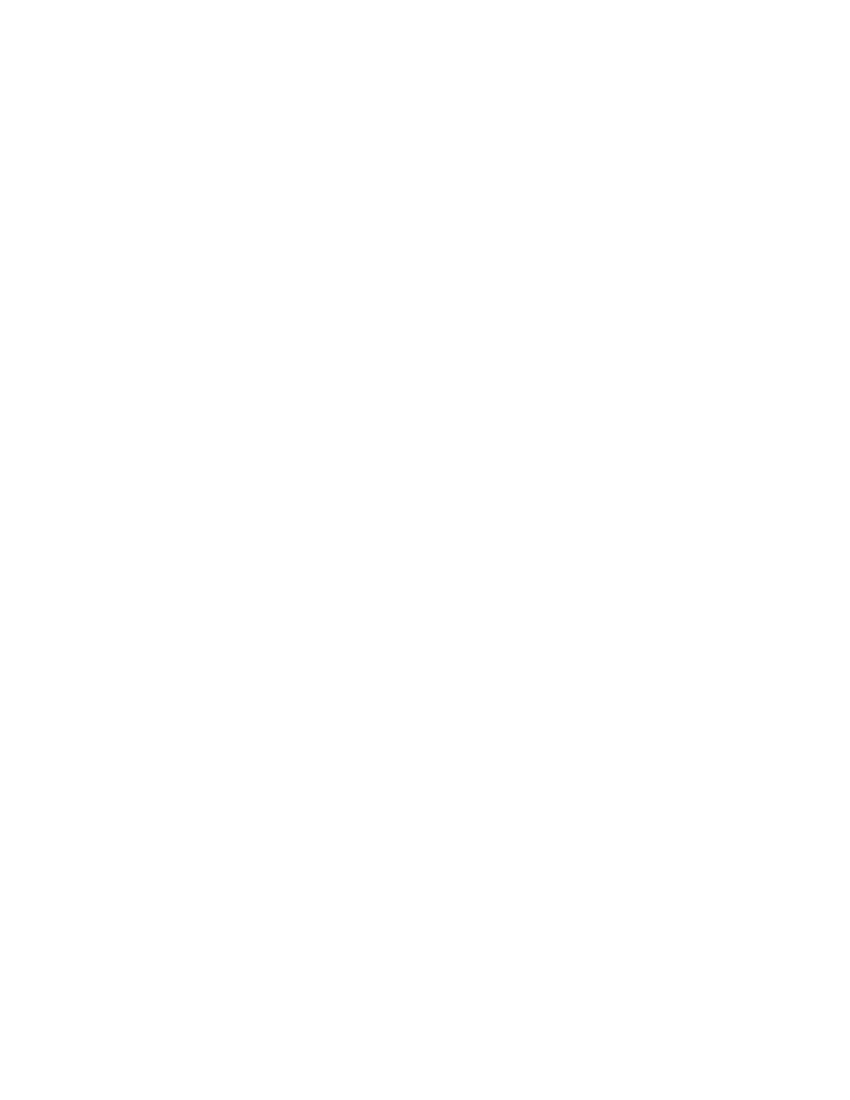

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import subjects
import pandas as pd
import seaborn as sns
from neuropy.plotting import Fig
from scipy import stats
from neuropy.plotting import plot_hypnogram

scatter_kw = dict(
    rasterized=True, s=6, edgecolors="w", linewidths=0, alpha=0.7, marker="o"
)
colors_scatter = subjects.colors_sd(1.2)
colors_bias = subjects.colors_sd(1.2)

grpdata = subjects.GroupData()
group = ["NSD", "SD"]

# ---- remaze_ev ----
ev_df, brainstates = grpdata.remaze_ev_example
ev_on_zt5h = grpdata.remaze_ev_on_zt0to5
colors_ev = subjects.colors_sd(1.2)
ev_on_post, remaze_ev_on_post_states = grpdata.remaze_ev_on_POST_pooled
corr_first5h_remaze = grpdata.remaze_first5_paircorr
corr_first5h_bootstrap = grpdata.remaze_first5_bootstrap

# ---incubator---------
# ev_on_post,_ = grpdata.remaze_ev_on_POST_example
# corr_sess = grpdata.remaze_corr_across_session
# corr_maze_remaze =grpdata.remaze_maze_paircorr
# corr_first5h_remaze_subsample =grpdata.remaze_first5_subsample
# corr_last5h_remaze =grpdata.remaze_last5_paircorr
# corr_first5_last5 =grpdata.post_first5_last5_paircorr
# ev_df = grpdata.remaze_ev

# ----- remaze temporal bias

# bias_df = grpdata.remaze_temporal_bias
# tb_com = grpdata.remaze_temporal_bias_com_correlation_across_session


# ---- ensembles
# ensemble_corr = grpdata.remaze_ensemble_corr_across_sess
# ensemble_activation = grpdata.remaze_ensemble_activation_across_sess
# activation_df = grpdata.remaze_activation_of_maze

fig = Fig(grid=(8, 6), fontsize=8, constrained_layout=True)
# fig.fig.suptitle('Figure 5',x=0)
filename = subjects.figpath_sd / "figure5"
caption = "cool plot"


### Example session EV

In [3]:
from neuropy.core import Epoch

gs1 = fig.subplot2grid(fig.gs[0, :3], grid=(5, 2))
kw = dict(alpha=0.5, linewidth=0, ec=None)
for g, grp in enumerate(["NSD", "SD"]):
    df = ev_df[ev_df.grp == grp]
    states = brainstates[brainstates.grp == grp]
    t, ev, ev_err, rev, rev_err = (
        df["Zt"],
        df["ev"],
        df["ev_std"],
        df["rev"],
        df["rev_std"],
    )

    ax = fig.subplot(gs1[1:, g])
    ax.fill_between(t, rev - rev_err, rev + rev_err, color="gray", **kw)
    ax.plot(t, rev, color="gray")
    ax.fill_between(t, ev - ev_err, ev + ev_err, color=colors_ev[g], **kw)
    ax.plot(t, ev, color=colors_ev[g])
    ax.set_ylim([0,0.15])
    ax.set_xlabel('Zt time (h)')
    if g==0:
        ax.set_ylabel('Explained variance')


    ax_hypno = fig.subplot(gs1[0,g])
    epoch = Epoch(states)
    plot_hypnogram(epoch,ax=ax_hypno,collapsed=False)


### paircorr first5h vs remaze

In [4]:
from matplotlib.colors import LogNorm
for i, grp in enumerate(["NSD", "SD"]):
    ax = fig.subplot(fig.gs[1, i])
    df = corr_first5h_remaze[corr_first5h_remaze["grp"] == grp]
    x, y = df.zt5h.values, df.remaze.values
    linreg = stats.linregress(x, y)
    xy = np.vstack([x,y])
    z = stats.gaussian_kde(xy,bw_method=0.1)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    sc = ax.scatter(x, y,c=z, cmap='rainbow',norm=LogNorm(0.7,628),**scatter_kw)
    if i==0:
        cax = ax.inset_axes([0, -0.4, 0.8, 0.05],transform=ax.transAxes)
        cb = plt.colorbar(sc,cax=cax,orientation='horizontal')
        cb.set_label('#pairs',fontsize=5)
        cb.outline.set_linewidth(0.9)
        cb.ax.tick_params(labelsize=5)
    ax.plot(x, linreg.intercept + linreg.slope * x, color=colors_ev[i])
    ax.text(0.3,0.45,f"r={linreg.rvalue.round(2)}",fontdict=dict(fontsize=8))
    ax.set_xlim([-0.17, 0.58])
    ax.set_ylim([-0.17, 0.58])
    ax.set_xlabel("Zt0-5")
    ax.set_ylabel("Remaze")

ax = fig.subplot(fig.gs[1, 2])
# ax.grid(True,zorder=-5)
sns.histplot(
    data=corr_first5h_bootstrap,
    x="r2_diff",
    ax=ax,
    color='#f7ac20',
    fill=True,
    element='step',
)
ax.set_ylabel('Counts')
ax.set_xlabel('R2 difference')


Text(0.5, 0, 'R2 difference')

### Remaze sessions remaze EV

In [5]:
subfig = fig.fig.add_subfigure(fig.gs[2:5, :3])
axs = subfig.subplots(6, 2, gridspec_kw=dict(height_ratios=[1, 4, 1, 4, 1, 4]))

kw = dict(alpha=0.5, linewidth=0, ec=None)
for g, grp in enumerate(["NSD", "SD"]):
    grp_df = ev_on_post[ev_on_post.grp == grp]
    subs = np.unique(grp_df["sub"].values)
    for i in range(len(subs)):
        df = grp_df[grp_df["sub"] == subs[i]]
        states = remaze_ev_on_post_states[
            remaze_ev_on_post_states["sub"] == subs[i]
        ].reset_index(drop=True)
        t, ev, ev_err, rev, rev_err = (
            df["Zt"],
            df["ev"],
            df["ev_std"],
            df["rev"],
            df["rev_std"],
        )

        ax = axs[2*i+1, g]
        ax.fill_between(t, ev - ev_err, ev + ev_err, color=colors_ev[g], **kw)
        ax.plot(t, ev, color=colors_ev[g])
        ax.set_ylim([0, 0.16])
        ax.set_xlabel("Zt time (h)")
        if g == 0:
            ax.set_ylabel("Explained variance")

        ax_hypno = axs[2*i, g]
        epoch = Epoch(states.copy())
        plot_hypnogram(epochs=epoch, ax=ax_hypno, collapsed=False)


### saving

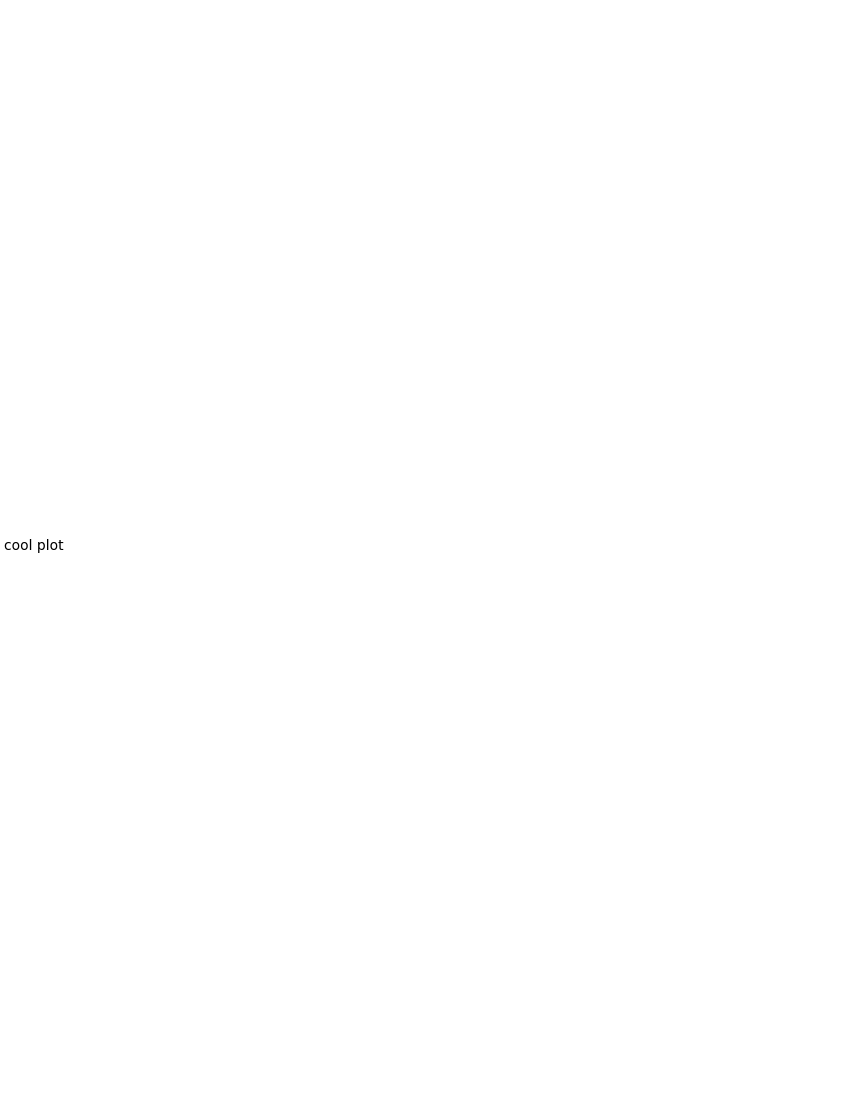

In [6]:
fig.savefig(filename,caption=caption)

### correlation across session

### paircorr last5h vs remaze

### paircorr maze vs remaze

### paircorr first5 vs last5

### ev

### temporal bias maze vs remaze

### maze activation on remaze

### temporal bias COM across sesssion

### Ensemble correlation across sesssion

### Ensemble activation across sesssion